# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2

In [37]:
np.random.seed(7)
n_samples = 100


def load_images(n_samples, path):
    filelist = glob.glob(path)
    if n_samples < len(filelist):
        filelist = np.random.choice(filelist, n_samples)
    return np.array([cv2.imread(fname) for fname in filelist])


apple_healty = load_images(n_samples, "images/Apple___healthy/*.JPG")
apple_black_rot = load_images(n_samples, "images/Apple___Black_rot/*.JPG")


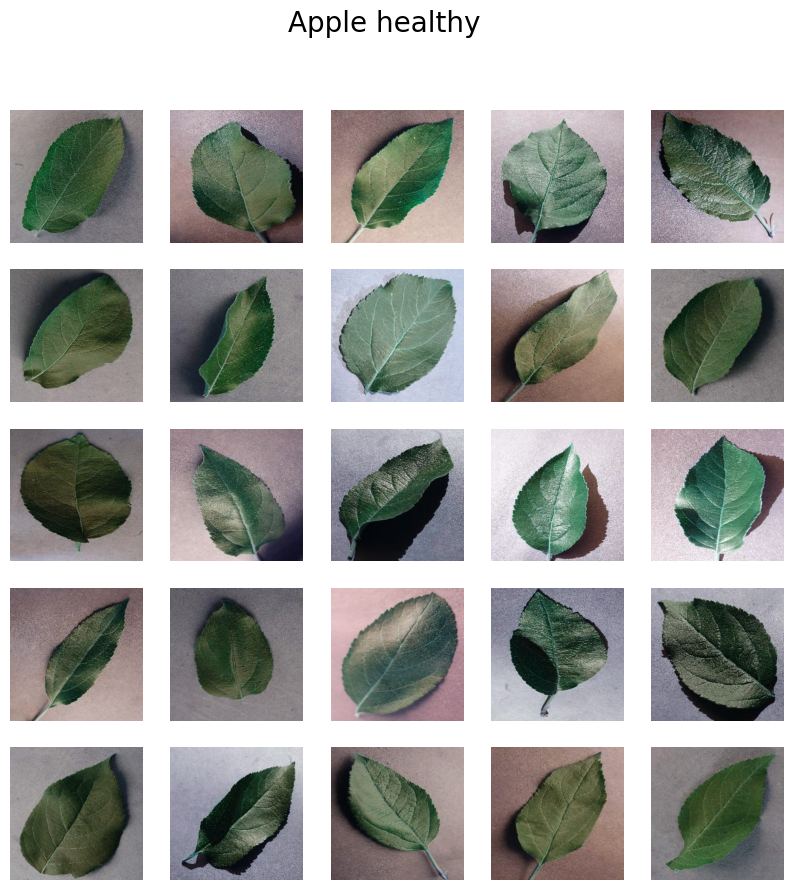

In [44]:
# plot some images in a 5 x 5 grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=20)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

plot_images(apple_healty, "Apple healthy")

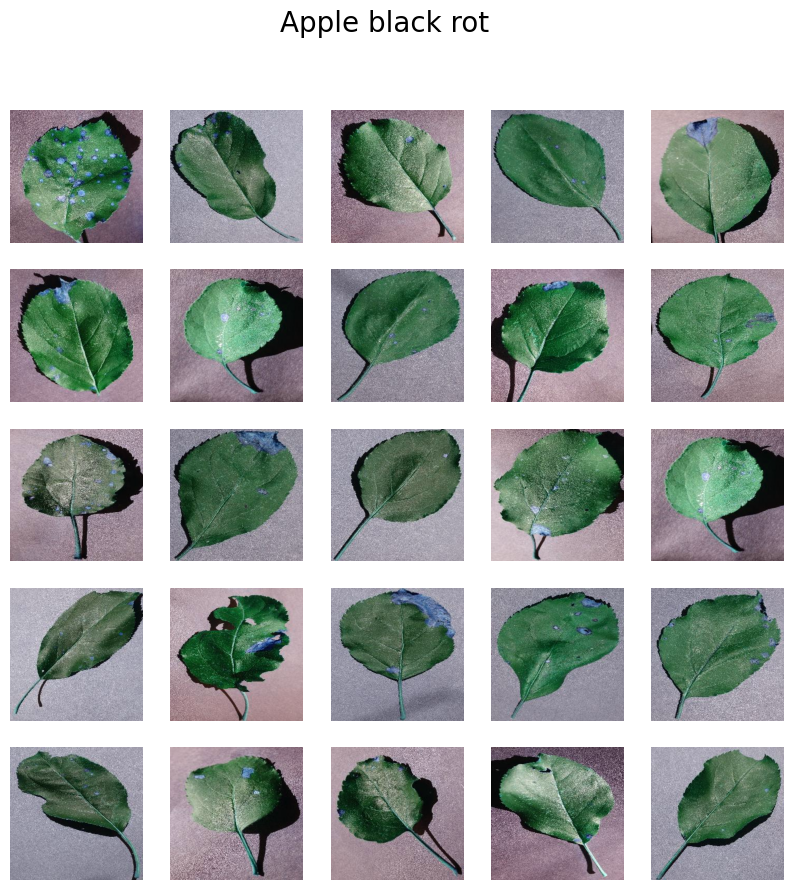

In [45]:
plot_images(apple_black_rot, "Apple black rot")